<a href="https://colab.research.google.com/github/ahmadbasyouni10/NYU-AI-School-Labs/blob/main/Lab_4_(advanced%3B_student)_2024_AI_School_Notebook_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Transfer Learning for Computer Vision**

In the previous section, we wrote our own convolutional neural network and trained it on the CIFAR 10 dataset. We learnt that we can stack multiple layers on top of each other to create a deep neural network and perform better than we would with a shallow network. But with increasing depth come more parameters and to train deeper networks, we have higher computational requirements. One way to bypass this is to reuse a network already trained on a large dataset, or *transfer learning*. In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [Stanford CS231n class notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), *because* it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

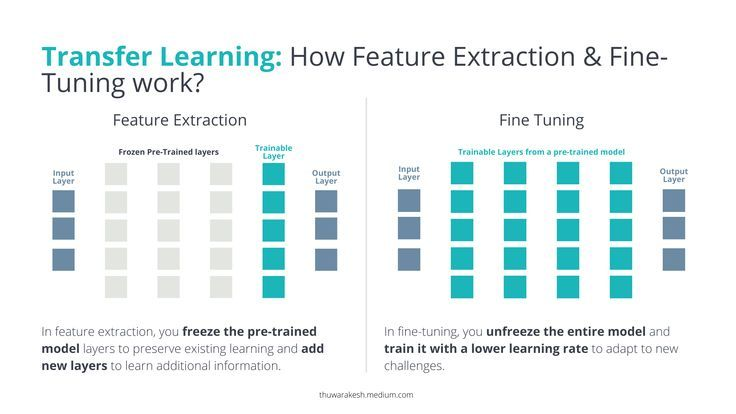

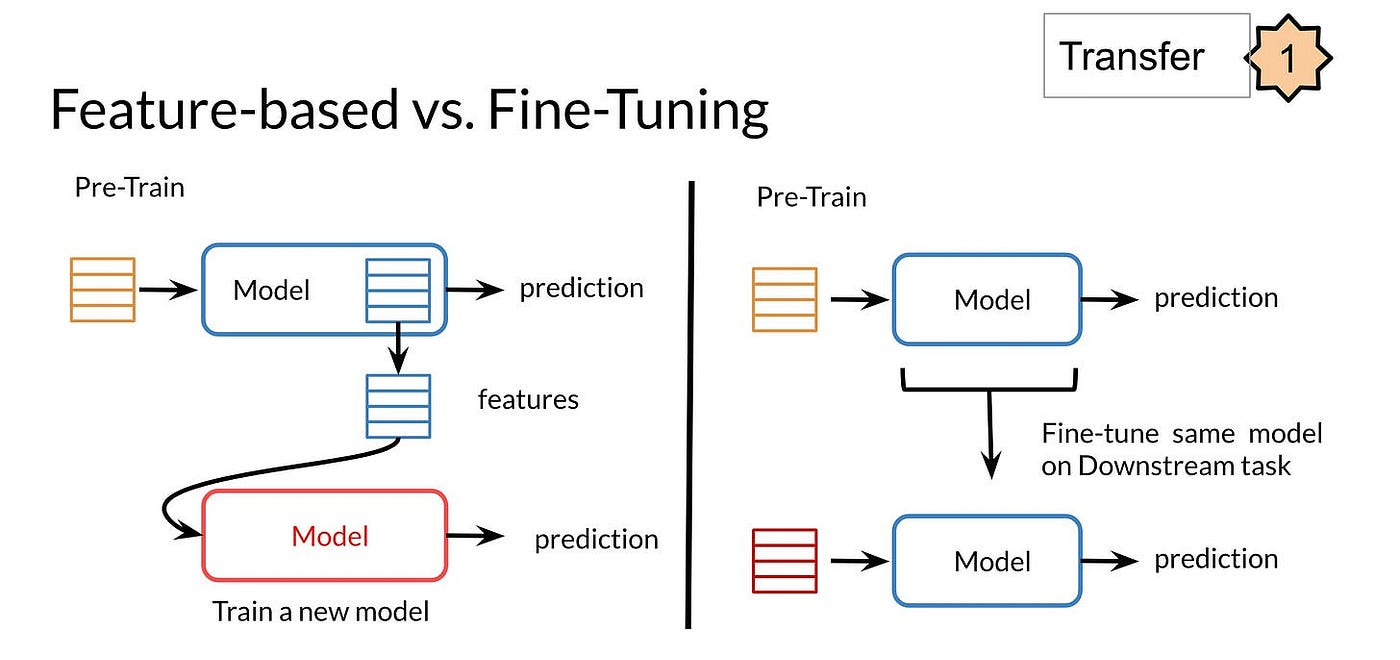

In [ ]:
# !pip install --upgrade matplotlib==3.1.3 torch torchvision numpy pillow
!pip install -U torch torchvision numpy pillow

In [ ]:
%matplotlib inline
# make all plots inline in the notebook

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Preparing the Data

Before building a model, we need data to train and validate it!

### Loading the Data

We will use `torchvision` and `torch.utils.data` packages for loading the data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

**Note** You can find the dataset [here](<https://download.pytorch.org/tutorial/hymenoptera_data.zip>), or you can run the commands below which will extract it to the current directory.

### What is Validation Data?

When we train a machine learning model, we use training data to do so. While testing, we use test data. We do this because it would be unfair (or biased) to evaluate the model using the same data it has been trained on. This is because, it's like testing students using a final exam that comprises of questions that are exactly the same as their past homework questions--they can just memorize the homework answers and get a great score, but that is a poor measure of their knowledge of the subject.

So validation data is just data that is held-out and not provided while training the model. We can then use it for evaluating different models by training them on the same datasets and comparing their validation accuracies on the validation dataset. While there are subtle differences, validation and test datasets are sometimes used interchangeably.

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip -d data/

--2024-06-06 17:35:33--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.31, 13.225.4.72, 13.225.4.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  81.1MB/s    in 0.6s    

2024-06-06 17:35:33 (81.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  


### Preprocessing the Data

Typically if your image data is not structured properly, you would need to manually load the (image, label) tuples into a dataloader for further manipulation.

But in this case we already have the desired structure with separate ``train`` and ``val`` folders and subfolders that are organized by label ('ant' or 'bees') that we can automatically load using the [``ImageFolder``](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) class from ``torchvision.datasets``.

You should look it up in the sidebar by clicking on the folder icon in the ``data`` folder.

Next, we will add some standard preprocessing to the data:

In [ ]:
# Data augmentation and normalization for training
# Normalization is important to bring the image -> tensor values into a 'normal' range
# An example of what this 'normal' range helps with is making convergence faster
# We also have normalization for the validation set of images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # crop the image randomly to a specific size
        transforms.RandomHorizontalFlip(),      # flip the image horizontally at random
        transforms.ToTensor(),                  # transform it back to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                 # for validation we do not want to randomly crop but rather Resize to 256 x 256
        transforms.CenterCrop(224),             # and then CenterCrop to 224 x 224
        transforms.ToTensor(),                  # then we apply both the same (last 2) transforms as above
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# define your data directory to be a string giving the path to the folder you just extracted
# all your images to, that is the 'hymenoptera_data' folder within the 'data' folder
data_dir = 'data/hymenoptera_data'

# use the ImageFolder class from the datasets module to automate the reading in of training and validation data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# define a dictionary containing a training and a validation dataloader
# remind yourself that a dataloader is just a list of (data, label) tuples that we can then manipulate easily
# for instance setting a batch size for loading or randomly shuffling the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# define a dictionary with two keys, 'train' and 'val'
# and values being the length of the dataset for each corresponding key in image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# we can obtain the class labels from the .classes property of the ImageFolder for train
# the ImageFolder for validation will also contain a subset of the same class labels so we can just use the labels from train
class_names = image_datasets['train'].classes

# use the GPU since we have a larger model to train this time compared to the last lab we did
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


If you're wondering why normalize with these specific values (you should be!), it's just the mean and standard deviation of millions of images present in the ImageNet dataset which is a standard dataset used in computer vision tasks, particularly image classification. [Here's](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2) a detailed explanation if you like.

### Looking at the Data

Even if your model perfectly fits the data, it doesn't help unless that data captures something you care about. Thus, you should always start by looking at your data. Does it appear as you expect? Are there preprocessing issues? Or perhaps the examples seem mislabeled?

Let's visualize a few training images, with our data augmentation, so as to understand exactly what we're asking the model to do.

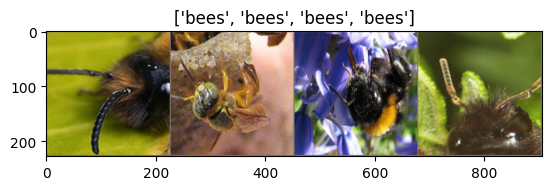

In [ ]:
def imshow(inp, title=None):
    """Plots the image represented by a tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Building the Model

Now that we've prepared the data, let's build the model!

### Defining the training loop

Now, let's write a general function to train a model. Here, we will illustrate:

- *Monitoring progress over training*: It is useful to print out diagnostic information during training in order to check that training is going well.
- *Early stopping*: To avoid overfitting by training too long, evaluate the model throughout training and keep a copy of the weights from when it performed best.

**For advanced reading only:**
In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    """
    Trains the model using the training data and returns the best model based on the validation data.
    """

    # note the current timestamp so that we can track how much time has elapsed
    since = time.time()

    # first step: set the best model to the current model's state_dict
    # we will use copy.deepcopy to ensure a new copy of the original object is created
    # instead of just returning a reference to the same object
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # train the model for num_epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                # in this mode, weights will be updated using the gradient
            else:
                model.eval()   # Set model to evaluate mode
                # no weight updates will occur during evaluation

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the (data, label) tuples in the dataloader for train and val
            # calculate the loss and update the weights if you are in the train phase
            # if you want to recollect the different steps look up the last lab
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                # this is to ensure you do not accidentally update the weights
                # using gradients from much older steps
                optimizer.zero_grad()

                # pass the inputs through the model
                # also called the forward run of the model
                # we only calculate the gradient and perform weight updates
                # if we are in the train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # advanced: use the learning rate scheduler
            # if phase == 'train' and scheduler is not None:
            #     scheduler.step()

            # the total loss for the epoch is divided by the number of images we have trained on
            epoch_loss = running_loss / dataset_sizes[phase]

            # similarly, the total accuracy is divided by the number of images
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # if the new model we are training performs better than the current model we have saved
            # then we overwrite the current weights with the new model's weights the same way
            # we also save the value of the best accuracy for the epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # calculate how much time has elapsed since we started training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load the best model weights
    model.load_state_dict(best_model_wts)

    # return the best model
    return model

### Defining a visualization for the predictions

Once the model is trained, it is helpful to look at its accuracy and loss; however, these kinds of metrics never give a complete picture. It is always important to look at the data and, in particular, the model's predictions on real examples.

Let's write a function to help us do just that!

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training

    # set the model to evaluation mode
    model.eval()
    images_so_far = 0

    # create a figure in matplotlib.pyplot
    fig = plt.figure()

    # we are not training so we do not want to update weights
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            # transfer the input tensor and the label to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # pass the validation data through the model to obtain the predictions
            outputs = model(inputs)

            # get the index of the maximum of the predictions for all classes
            # and consider that as the predicted label
            _, preds = torch.max(outputs, 1)

            # create a grid and plot as many images as in num_images
            for j in range(inputs.size()[0]):
                # count how many images have been plotted
                images_so_far += 1
                # create a grid of subplots
                ax = plt.subplot(num_images//2, 2, images_so_far)
                # don't plot the axis
                ax.axis('off')
                # set each subplot's title as the predicted label for the image
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                # convert the jth row of the input tensor back to an image and plot it
                imshow(inputs.cpu().data[j])

                # stop plotting further images in the grid
                # return the model to the same training mode that it was in before
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning a ConvNet

Now that we've defined the training loop and figured out how to visualize our predictions, let's load and fine-tune a pretrained model. We will:

1. Load the pretrained model,
2. Reset the final fully connected layer, then
3. Further train the entire model on our dataset.

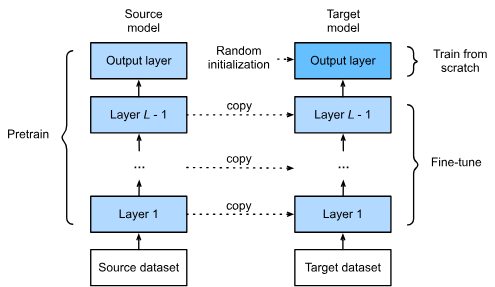

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2 because we have just two classes--ants and bees
# In other problems it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# transfer the model to the GPU
model_ft = model_ft.to(device)

# define the loss function we want to use (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# advanced: Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train and evaluate!

Finally, we're ready to train and evaluate!

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8282 Acc: 0.5123
val Loss: 0.9142 Acc: 0.4771

Epoch 1/24
----------
train Loss: 0.8337 Acc: 0.5082
val Loss: 0.9271 Acc: 0.4771

Epoch 2/24
----------
train Loss: 0.8519 Acc: 0.5041
val Loss: 0.9249 Acc: 0.4771

Epoch 3/24
----------
train Loss: 0.8546 Acc: 0.5082
val Loss: 0.9622 Acc: 0.4641

Epoch 4/24
----------
train Loss: 0.8428 Acc: 0.5041
val Loss: 0.9763 Acc: 0.4510

Epoch 5/24
----------
train Loss: 0.8469 Acc: 0.4959
val Loss: 0.9629 Acc: 0.4510

Epoch 6/24
----------
train Loss: 0.8512 Acc: 0.5082
val Loss: 0.9826 Acc: 0.4510

Epoch 7/24
----------
train Loss: 0.8331 Acc: 0.4918
val Loss: 0.9230 Acc: 0.4706

Epoch 8/24
----------
train Loss: 0.8308 Acc: 0.5082
val Loss: 0.9928 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.8391 Acc: 0.5082
val Loss: 0.9601 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.8481 Acc: 0.5041
val Loss: 0.9487 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.8274 Acc: 0.5000
val Loss: 0.9545 Acc: 0.4510

Epoch 12/24
----------
t

Let's look at the predictions to double check what the model learned.

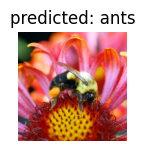

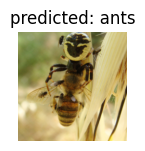

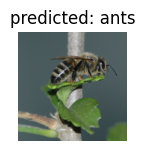

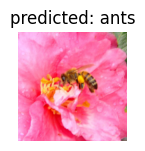

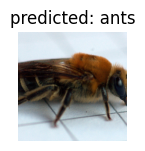

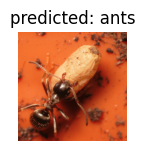

In [ ]:
visualize_model(model_ft)

### ConvNets as fixed feature extractors

So far, we got a pretrained model and finetuned it on our dataset. But what if we wanted to keep the more general, pretrained features as-is, and instead just learn a specialized function on top for our use case? For example, we might want to compute the features once, then reuse them across multiple applications.

We need to freeze all of the network except the final layer. We need to set `requires_grad == False` to freeze the parameters so that the gradients are not computed in `backward()`.

You can read more about this in the [documentation](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)

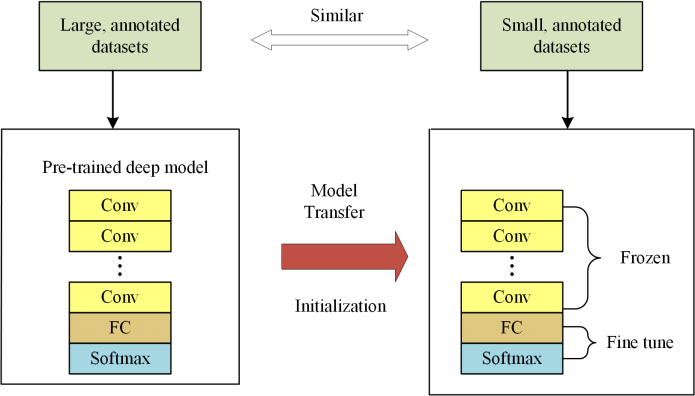


In [ ]:
# get the resnet18 pretrained model from torchvision.models
model_conv = torchvision.models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
# so we need to iterate over each parameter in model_conv.parameters()
# and manually set requires_grad=False.
for param in model_conv.parameters():
    param.requires_grad = False

# we just have two classes to predict so the final no. of output features is 2
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# transfer the model to the GPU
model_conv = model_conv.to(device)

# define the criterion as CrossEntropyLoss from the nn module
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# advanced: Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         num_epochs=25)

# advanced: use the learning-rate scheduler to adjsut your learning rate
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.9264 Acc: 0.5041
val Loss: 1.0298 Acc: 0.4444

Epoch 1/24
----------
train Loss: 0.8951 Acc: 0.5041
val Loss: 1.0428 Acc: 0.4444

Epoch 2/24
----------
train Loss: 0.9282 Acc: 0.5082
val Loss: 1.0396 Acc: 0.4379

Epoch 3/24
----------
train Loss: 0.9198 Acc: 0.5041
val Loss: 1.0318 Acc: 0.4379

Epoch 4/24
----------
train Loss: 0.9064 Acc: 0.5082
val Loss: 1.0450 Acc: 0.4510

Epoch 5/24
----------
train Loss: 0.9209 Acc: 0.5041
val Loss: 1.0778 Acc: 0.4314

Epoch 6/24
----------
train Loss: 0.8922 Acc: 0.5041
val Loss: 1.0330 Acc: 0.4444

Epoch 7/24
----------
train Loss: 0.9279 Acc: 0.5000
val Loss: 0.9953 Acc: 0.4444

Epoch 8/24
----------
train Loss: 0.9313 Acc: 0.5000
val Loss: 1.0179 Acc: 0.4444

Epoch 9/24
----------
train Loss: 0.9163 Acc: 0.5082
val Loss: 1.0240 Acc: 0.4379

Epoch 10/24
----------
train Loss: 0.9112 Acc: 0.5082
val Loss: 1.0592 Acc: 0.4379

Epoch 11/24
----------
train Loss: 0.9040 Acc: 0.5000
val Loss: 1.0977 Acc: 0.4314

Epoch 12/24
----------
t

Let's look at those predictions!

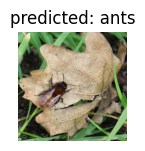

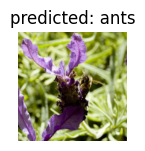

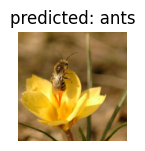

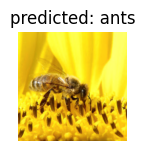

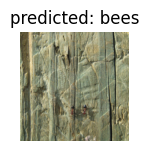

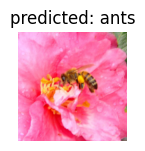

In [ ]:
# call the visualize_model function with the trained model as an argument
visualize_model(model_conv)

# turn off interactive mode for plots
plt.ioff()

# show the plot that has been generated
plt.show()

## Conclusion

We saw how to build a standard computer vision model by:

1. **Preparing our data**, including downloading, preprocessing, and visualizing it.
2. **Starting from a pretrained model**, such as ResNet18 trained on ImageNet.
3. **Transferring the model to our data** by either fine-tuning the whole thing or training just the last layer on top of the fixed, pretrained features.

That's it!

Reference
---------

Heavily based on the Pytorch Tutorial by [Sasank Chilamkurthy](https://chsasank.github.io)

## Homework Assignment

We saw how to finetune the ResNet-18 model on our dataset. But what if we want to use a different model as a feature extractor instead of the ResNet-18 model? Let's try using a ``googlenet`` model from ``torchvision.models`` instead. Remember that we want it to be pretrained!

In [ ]:
# get the googlenet pretrained model from torchvision.models
model_gnet = ...

# Parameters of newly constructed modules have requires_grad=True by default
# so we need to iterate over each parameter in model_conv.parameters()
# and manually
for param in model_gnet.parameters():
    ...

# we are adding a fully connected layer on top
# with the final number of output classes that we need
num_ftrs_gnet = ...
model_gnet.fc = ...

# transfer the model to the GPU
model_gnet = ...

# define the criterion as CrossEntropyLoss from the nn module
criterion_gnet = ...

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_gnet = ...

Now let's train the last layer of the model to predict ants and bees from our dataset.

In [ ]:
model_conv = ...

# Bonus: Cutting-edge Computer Vision

## Generative Adversarial Network

While we won't be deep-diving into what a generative adversarial network is in this tutorial, the point of doing this part is to show that really, all you need to do to implement machine learning models involves two blocks of code like this example where we can simply download a pretrained model and in this case pass some random numbers using the variable `latents` through it in order to obtain realistic-looking faces that are generated by AI. It's incredibly powerful and also equally thought-provoking that you can go from random numbers to artificially-generated faces in a few lines of code!

In [ ]:
model = torch.hub.load('ndahlquist/pytorch-hub-stylegan:0.0.1', 'style_gan', pretrained=True)

In [ ]:
%matplotlib inline

model.eval()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

nb_rows = 4
nb_cols = 4
nb_samples = nb_rows * nb_cols
latents = torch.randn(nb_samples, 512, device=device)
with torch.no_grad():
    imgs = model(latents)
    # normalization to 0..1 range
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(20, 20))
plt.imshow(imgs.permute(1, 2, 0).detach().numpy())

plt.show()

## Diffusion Models

Denoising Diffusion Probabilistic Models (DDPMs) are a class of generative models that have shown to be capable of high-quality image generation. They have beaten GANs in image generation (https://arxiv.org/pdf/2105.05233) and are the models that power StableDiffusion, DALL-E and MidJourney. While the theory behind diffusion models is fairly mathematical and complex, diffusion models are trained by learning to reverse the iterative forward noising (or "diffusion") process of a data distribution, where random noise is added to data. New data is generated by the reverse diffusion process, where original data distribution is retrieved by iteratively removing the noise.

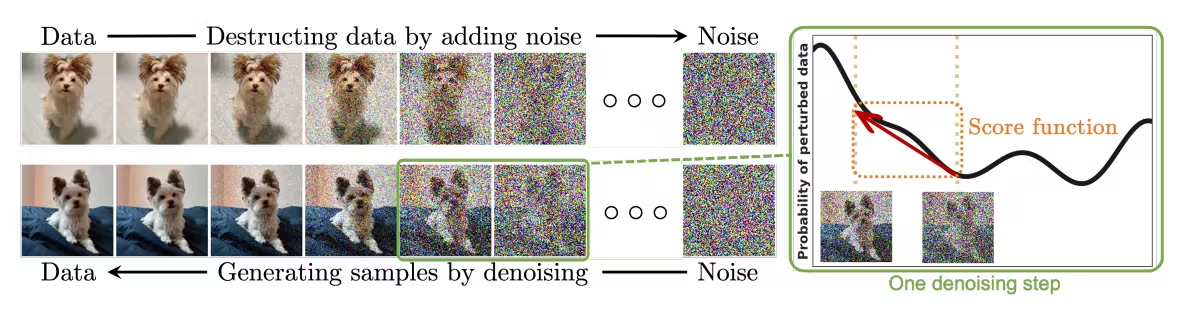

Source: https://arxiv.org/pdf/2209.00796

We can generate images by loading pretrained StableDiffusion model from the HuggingFace Hub.

StableDiffusion is a *conditional* diffusion model where the textual prompt serves as the condition when generating samples using the reverse process, to guide the data generation.

In [ ]:
%%capture

!pip install --upgrade diffusers transformers scipy
!pip install --U accelerate

In [ ]:
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DiffusionPipeline

In [ ]:
# Load the pre-trained Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

In [ ]:
# Provide the prompt and number of denoising steps
prompt = "A futuristic cityscape with flying cars"

num_inference_steps = 50  # Number of denoising steps

# Generate an image
with torch.autocast("cuda"):
    imgs = pipeline(prompt, num_inference_steps=num_inference_steps).images

# Plot the generated image
plt.figure(figsize=(10, 10))
plt.imshow(imgs[0])
plt.show()
